# Build Meta Dictionary Using DeepSeek API

# Import Required Libraries

In [1]:
# Core libraries for data manipulation and database connectivity
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Database connectivity
import sqlalchemy
from sqlalchemy import create_engine, text, MetaData, inspect
import pymssql
import urllib.parse

# Excel file handling
import openpyxl
from openpyxl import Workbook

# Environment variables and configuration
from dotenv import load_dotenv

# LLM API calls
import requests
import json

# Interactive widgets
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Set up plotting styles
plt.style.use('default')
sns.set_palette("husl")
pyo.init_notebook_mode(connected=True)

# Load environment variables from .env file
load_dotenv(".env")

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🗄️ SQLAlchemy version: {sqlalchemy.__version__}")
print(f"🔌 pymssql version: {pymssql.__version__}")

# Check for required environment variables
required_env_vars = ['MSSQL_SERVER', 'MSSQL_DATABASE']
missing_vars = [var for var in required_env_vars if not os.getenv(var)]

if missing_vars:
    print(f"\n⚠️  Missing required environment variables: {missing_vars}")
    print("Please set these in your .env file or environment")
else:
    print("✅ Required database environment variables found")

# Check for LLM API keys
llm_providers = {
    'OpenAI': 'OPENAI_API_KEY',
    'Anthropic': 'ANTHROPIC_API_KEY', 
    'Google': 'GOOGLE_API_KEY',
    'DeepSeek': 'DEEPSEEK_API_KEY'
}

available_providers = []
for provider, env_var in llm_providers.items():
    if os.getenv(env_var):
        available_providers.append(provider)
        print(f"✅ {provider} API key found")
    else:
        print(f"❌ {provider} API key missing ({env_var})")

if not available_providers:
    print("\n⚠️  No LLM API keys found! Please set at least one API key.")
else:
    print(f"\n🤖 Available LLM providers: {', '.join(available_providers)}")

✅ All libraries imported successfully!
📊 Pandas version: 2.2.3
🗄️ SQLAlchemy version: 2.0.42
🔌 pymssql version: 2.3.8
✅ Required database environment variables found
✅ OpenAI API key found
✅ Anthropic API key found
✅ Google API key found
✅ DeepSeek API key found

🤖 Available LLM providers: OpenAI, Anthropic, Google, DeepSeek


# Connect to MSSQL Database

This section establishes a connection to the MSSQL Server database using SQLAlchemy with the pymssql driver.

In [2]:
class MSSQLConnector:
    """
    MSSQL Database Connector using SQLAlchemy and pymssql
    """
    
    def __init__(self):
        self.server = os.getenv('MSSQL_SERVER')
        self.database = os.getenv('MSSQL_DATABASE')
        self.username = os.getenv('MSSQL_USERNAME')
        self.password = os.getenv('MSSQL_PASSWORD')
        self.port = int(os.getenv('MSSQL_PORT', os.getenv('MSSQL_PORT')))
        self.use_windows_auth = os.getenv('MSSQL_USE_WINDOWS_AUTH', 'false').lower() == 'true'
        
        self.engine = None
        self.connection_string = None
        
    def create_connection_string(self):
        """Create the connection string for MSSQL using pymssql"""
        if self.use_windows_auth:
            # Windows Authentication - pymssql doesn't support this directly
            # You would need to use SSPI/Kerberos which is complex
            raise ValueError(
                "Windows Authentication is not supported with pymssql. "
                "Please use SQL Server authentication with username and password."
            )
        else:
            # SQL Server Authentication
            if not self.username or not self.password:
                raise ValueError("Username and password required for SQL Server authentication")
            
            # URL encode the password to handle special characters
            encoded_password = urllib.parse.quote_plus(self.password)
            encoded_username = urllib.parse.quote_plus(self.username)
            
            # pymssql connection string format
            self.connection_string = (
                f"mssql+pymssql://{encoded_username}:{encoded_password}@"
                f"{self.server}:{self.port}/{self.database}"
            )
        
        return self.connection_string
    
    def connect(self):
        """Establish database connection"""
        try:
            if not self.connection_string:
                self.create_connection_string()
            
            self.engine = create_engine(self.connection_string)
            
            # Test the connection
            with self.engine.connect() as conn:
                result = conn.execute(text("SELECT 1 as test")).fetchone()
                if result[0] == 1:
                    print("✅ Successfully connected to MSSQL database!")
                    print(f"📊 Server: {self.server}:{self.port}")
                    print(f"🗄️ Database: {self.database}")
                    return True
        
        except Exception as e:
            print(f"❌ Failed to connect to database: {str(e)}")
            print("\n💡 Troubleshooting tips:")
            print("1. Check if SQL Server is running")
            print("2. Verify server name and database name")
            print("3. Check credentials (username and password)")
            print("4. Ensure SQL Server is configured to allow TCP/IP connections")
            print("5. Check firewall settings and network connectivity")
            print("6. Verify the port number (default: 1433)")
            return False
    
    def execute_query(self, query, params=None):
        """Execute a SQL query and return results as DataFrame"""
        try:
            if not self.engine:
                print("❌ No database connection. Call connect() first.")
                return None
            
            if params:
                df = pd.read_sql_query(text(query), self.engine, params=params)
            else:
                df = pd.read_sql_query(text(query), self.engine)
            
            return df
        
        except Exception as e:
            print(f"❌ Error executing query: {str(e)}")
            return None
    
    def get_tables(self):
        """Get list of all tables in the database"""
        query = """
        SELECT 
            TABLE_SCHEMA,
            TABLE_NAME,
            TABLE_TYPE
        FROM INFORMATION_SCHEMA.TABLES
        WHERE TABLE_TYPE = 'BASE TABLE'
        ORDER BY TABLE_SCHEMA, TABLE_NAME
        """
        return self.execute_query(query)
    
    def get_columns(self, schema_name=None, table_name=None):
        """Get column information for tables"""
        query = """
        SELECT 
            TABLE_SCHEMA,
            TABLE_NAME,
            COLUMN_NAME,
            DATA_TYPE,
            CHARACTER_MAXIMUM_LENGTH,
            IS_NULLABLE,
            COLUMN_DEFAULT,
            ORDINAL_POSITION
        FROM INFORMATION_SCHEMA.COLUMNS
        """
        
        conditions = []
        params = {}
        
        if schema_name:
            conditions.append("TABLE_SCHEMA = :schema_name")
            params['schema_name'] = schema_name
            
        if table_name:
            conditions.append("TABLE_NAME = :table_name")
            params['table_name'] = table_name
        
        if conditions:
            query += " WHERE " + " AND ".join(conditions)
        
        query += " ORDER BY TABLE_SCHEMA, TABLE_NAME, ORDINAL_POSITION"
        
        return self.execute_query(query, params if params else None)

# Initialize the database connector
db_connector = MSSQLConnector()

# Test the connection
if db_connector.connect():
    print("\n🚀 Database connector ready for use!")
else:
    print("\n❌ Database connection failed. Please check your configuration.")

✅ Successfully connected to MSSQL database!
📊 Server: localhost:1434
🗄️ Database: AdventureWorks2019

🚀 Database connector ready for use!


# Extract Database Metadata and Save to local Excel File 

In [6]:
class DatabaseMetadataExtractor:
    """
    Extract comprehensive metadata from MSSQL database
    """
    
    def __init__(self, db_connector):
        self.db_connector = db_connector
        self.metadata_df = None
        
    def extract_full_metadata(self):
        """Extract comprehensive metadata including extended properties"""
        query = """
        SELECT 
            t.TABLE_SCHEMA,
            t.TABLE_NAME,
            c.COLUMN_NAME,
            c.DATA_TYPE,
            c.CHARACTER_MAXIMUM_LENGTH,
            c.NUMERIC_PRECISION,
            c.NUMERIC_SCALE,
            c.IS_NULLABLE,
            c.COLUMN_DEFAULT,
            c.ORDINAL_POSITION,
            -- Try to get column descriptions from extended properties
            ISNULL(ep.value, '') as COLUMN_DESCRIPTION,
            -- Additional table information
            t.TABLE_TYPE,
            -- Create a readable data type description
            CASE 
                WHEN c.DATA_TYPE IN ('varchar', 'char', 'nvarchar', 'nchar') 
                    THEN c.DATA_TYPE + '(' + CAST(c.CHARACTER_MAXIMUM_LENGTH as varchar(10)) + ')'
                WHEN c.DATA_TYPE IN ('decimal', 'numeric') 
                    THEN c.DATA_TYPE + '(' + CAST(c.NUMERIC_PRECISION as varchar(10)) + ',' + CAST(c.NUMERIC_SCALE as varchar(10)) + ')'
                ELSE c.DATA_TYPE
            END as FULL_DATA_TYPE
        FROM INFORMATION_SCHEMA.TABLES t
        INNER JOIN INFORMATION_SCHEMA.COLUMNS c 
            ON t.TABLE_SCHEMA = c.TABLE_SCHEMA 
            AND t.TABLE_NAME = c.TABLE_NAME
        LEFT JOIN sys.tables st 
            ON st.name = t.TABLE_NAME 
            AND st.schema_id = SCHEMA_ID(t.TABLE_SCHEMA)
        LEFT JOIN sys.columns sc 
            ON sc.object_id = st.object_id 
            AND sc.name = c.COLUMN_NAME
        LEFT JOIN sys.extended_properties ep 
            ON ep.major_id = sc.object_id 
            AND ep.minor_id = sc.column_id 
            AND ep.name = 'MS_Description'
        WHERE t.TABLE_TYPE = 'BASE TABLE'
        ORDER BY t.TABLE_SCHEMA, t.TABLE_NAME, c.ORDINAL_POSITION
        """
        
        print("🔍 Extracting database metadata...")
        self.metadata_df = self.db_connector.execute_query(query)
        
        if self.metadata_df is not None:
            print(f"✅ Successfully extracted metadata for {len(self.metadata_df)} columns")
            print(f"📊 Found {self.metadata_df['TABLE_NAME'].nunique()} tables")
            print(f"🏷️ Schemas: {', '.join(self.metadata_df['TABLE_SCHEMA'].unique())}")
            
            return self.metadata_df
        else:
            print("❌ Failed to extract metadata")
            return None
    
    def save_to_excel(self, filename="database_metadata.xlsx"):
        """Save metadata to Excel file"""
        if self.metadata_df is None:
            print("❌ No metadata to save. Run extract_full_metadata() first.")
            return False
        
        try:
            filepath = os.path.join(os.getcwd(), filename)
            
            with pd.ExcelWriter(filepath, engine='openpyxl') as writer:
                # Main metadata sheet
                self.metadata_df.to_excel(writer, sheet_name='Metadata', index=False)
                
                # Summary sheet
                summary_data = {
                    'Metric': [
                        'Total Tables',
                        'Total Columns', 
                        'Schemas',
                        'Data Types Used',
                        'Tables with Descriptions',
                        'Columns with Descriptions'
                    ],
                    'Value': [
                        self.metadata_df['TABLE_NAME'].nunique(),
                        len(self.metadata_df),
                        ', '.join(self.metadata_df['TABLE_SCHEMA'].unique()),
                        ', '.join(self.metadata_df['DATA_TYPE'].unique()),
                        len(self.metadata_df[self.metadata_df['COLUMN_DESCRIPTION'].notna()]['TABLE_NAME'].unique()),
                        len(self.metadata_df[self.metadata_df['COLUMN_DESCRIPTION'].notna()])
                    ]
                }
                
                summary_df = pd.DataFrame(summary_data)
                summary_df.to_excel(writer, sheet_name='Summary', index=False)
                
                # Table list sheet
                table_summary = self.metadata_df.groupby(['TABLE_SCHEMA', 'TABLE_NAME']).agg({
                    'COLUMN_NAME': 'count',
                    'COLUMN_DESCRIPTION': lambda x: x.notna().sum()
                }).rename(columns={
                    'COLUMN_NAME': 'Column_Count',
                    'COLUMN_DESCRIPTION': 'Described_Columns'
                }).reset_index()
                
                table_summary.to_excel(writer, sheet_name='Tables', index=False)
            
            print(f"✅ Metadata saved to: {filepath}")
            print(f"📊 File size: {os.path.getsize(filepath)} bytes")
            return True
            
        except Exception as e:
            print(f"❌ Error saving to Excel: {str(e)}")
            return False

# Initialize metadata extractor
metadata_extractor = DatabaseMetadataExtractor(db_connector)

# Extract metadata if database connection is available
if db_connector.engine:
    metadata_df = metadata_extractor.extract_full_metadata()
    # If COLUMN_DESCRIPTION contains keywords in ['Clustered index','Nonclustered index'], exclude such rows
    index_keywords = ['Clustered index', 'Nonclustered index']
    mask = ~metadata_df['COLUMN_DESCRIPTION'].astype(str).str.contains('|'.join(index_keywords), case=False, na=False)
    metadata_df = metadata_df[mask].reset_index(drop=True)
    print(f"✅ Filtered out index-related rows. Remaining rows: {len(metadata_df)}")

    # Remove clustered and non-clustered column indices
    metadata_df.drop_duplicates(subset=["TABLE_SCHEMA","TABLE_NAME","COLUMN_NAME","DATA_TYPE","TABLE_TYPE"],inplace=True)
    
    if metadata_df is not None:
        print("\n📋 Sample metadata:")
        display(metadata_df.head(10))
        
        # Save to Excel
        if metadata_extractor.save_to_excel(f"metadata_{db_connector.database}.xlsx"):
            print("\n💾 Metadata successfully saved to Excel file!")
    else:
        print("\n❌ Failed to extract metadata")
else:
    print("\n⚠️ No database connection available. Skipping metadata extraction.")


🔍 Extracting database metadata...
✅ Successfully extracted metadata for 648 columns
📊 Found 71 tables
🏷️ Schemas: dbo, HumanResources, Person, Production, Purchasing, Sales
✅ Filtered out index-related rows. Remaining rows: 485

📋 Sample metadata:


,TABLE_SCHEMA,TABLE_NAME,COLUMN_NAME,DATA_TYPE,CHARACTER_MAXIMUM_LENGTH,NUMERIC_PRECISION,NUMERIC_SCALE,IS_NULLABLE,COLUMN_DEFAULT,ORDINAL_POSITION,COLUMN_DESCRIPTION,TABLE_TYPE,FULL_DATA_TYPE
0,dbo,AWBuildVersion,SystemInformationID,tinyint,NaN,3.0,0.0,NO,None,1,b'Primary key for AWBuildVersion records.',BASE TABLE,tinyint
1,dbo,AWBuildVersion,Database Version,nvarchar,25.0,NaN,NaN,NO,None,2,b'Version number of the database in 9.yy.mm.dd...,BASE TABLE,nvarchar(25)
2,dbo,AWBuildVersion,VersionDate,datetime,NaN,NaN,NaN,NO,None,3,b'Date and time the record was last updated.',BASE TABLE,datetime
3,dbo,AWBuildVersion,ModifiedDate,datetime,NaN,NaN,NaN,NO,(getdate()),4,b'Date and time the record was last updated.',BASE TABLE,datetime
4,dbo,DatabaseLog,DatabaseLogID,int,NaN,10.0,0.0,NO,None,1,b'Primary key for DatabaseLog records.',BASE TABLE,int
5,dbo,DatabaseLog,PostTime,datetime,NaN,NaN,NaN,NO,None,2,b'The date and time the DDL change occurred.',BASE TABLE,datetime
6,dbo,DatabaseLog,DatabaseUser,nvarchar,128.0,NaN,NaN,NO,None,3,b'The user who implemented the DDL change.',BASE TABLE,nvarchar(128)
7,dbo,DatabaseLog,Event,nvarchar,128.0,NaN,NaN,NO,None,4,b'The type of DDL statement that was executed.',BASE TABLE,nvarchar(128)
8,dbo,DatabaseLog,Schema,nvarchar,128.0,NaN,NaN,YES,None,5,b'The schema to which the changed object belon...,BASE TABLE,nvarchar(128)
9,dbo,DatabaseLog,Object,nvarchar,128.0,NaN,NaN,YES,None,6,b'The object that was changed by the DDL statm...,BASE TABLE,nvarchar(128)


✅ Metadata saved to: /home/ubuntu/git-projects/personal/github.com/elasticsearch_opensearch/opensearch/my_tutorial/scripts/5. REALTIME_PROJECTS/4. text_to_bi/opensearch-RAG/metadata_AdventureWorks2019.xlsx
📊 File size: 50033 bytes

💾 Metadata successfully saved to Excel file!


# Build column descriptions metadata

In [7]:
# Configuration and Setup
DEEPSEEK_API_URL = "https://api.deepseek.com/v1/chat/completions"
SAMPLING_COUNT = 10
SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA = ["dbo"]

load_dotenv(".env")
# You'll need to set your DeepSeek API key here
# Get your API key from: https://platform.deepseek.com/
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")  # Replace with your actual API key

if DEEPSEEK_API_KEY == "your_deepseek_api_key_here":
    print("⚠️  WARNING: Please set your DeepSeek API key in the DEEPSEEK_API_KEY variable")
else:
    print("✅ Configuration loaded successfully!")

✅ Configuration loaded successfully!


# Sequential calls to LLM

In [8]:
# Define DeepSeek API Call Function
def call_deepseek_api(sample_values, column_name, table_name, data_type):
    """
    Call DeepSeek API to generate a description for the sampled data
    """
    if not DEEPSEEK_API_KEY or DEEPSEEK_API_KEY == "your_deepseek_api_key_here":
        # Return a placeholder description if API key is not set
        return f"AI description needed for {column_name} column"
    
    try:
        # Prepare the prompt with sample values
        sample_str = ", ".join([str(val) for val in sample_values[:10] if val is not None])
        
        if not sample_str:
            return f"{data_type} column in {table_name}"
        
        prompt = f"""
        Based on these sample values from the column '{column_name}' (data type: {data_type}) in the table '{table_name}':
        {sample_str}
        
        Please provide a concise description of what this column contains in less than 40 words.
        Focus on the type of data, its purpose, and any patterns you observe.
        """
        
        headers = {
            "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
            "Content-Type": "application/json"
        }
        
        data = {
            "model": "deepseek-chat",
            "messages": [
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            "max_tokens": 300,
            "temperature": 0.1
        }
        
        response = requests.post(DEEPSEEK_API_URL, headers=headers, json=data, timeout=30)
        
        if response.status_code == 200:
            result = response.json()
            description = result["choices"][0]["message"]["content"].strip()
            return description
        else:
            print(f"  ❌ API Error {response.status_code}: {response.text}")
            return f"API error for {column_name}"
            
    except Exception as e:
        print(f"  ❌ Exception calling API for {column_name}: {str(e)}")
        return f"Error generating description for {column_name}"


def get_sample_values_from_db(db_connector, schema, table, column, sample_size=SAMPLING_COUNT):
    """
    Get random sample values from the database for a specific column
    """
    try:
        # Build query to get random sample values
        query = f"""
        SELECT TOP {sample_size} [{column}]
        FROM [{schema}].[{table}]
        WHERE [{column}] IS NOT NULL
        ORDER BY NEWID()
        """
        
        result_df = db_connector.execute_query(query)
        
        if result_df is not None and not result_df.empty:
            # Return list of values
            return result_df[column].tolist()
        else:
            return []
            
    except Exception as e:
        print(f"  ⚠️  Error sampling {schema}.{table}.{column}: {str(e)}")
        return []


def add_inferred_descriptions_to_metadata(metadata_df, db_connector, schemas_to_exclude=None):
    """
    Add INFERRED_COLUMN_DESCRIPTION column to metadata_df by querying the database
    and using DeepSeek API to generate descriptions
    
    Parameters:
    - metadata_df: DataFrame with metadata (must have TABLE_SCHEMA, TABLE_NAME, COLUMN_NAME, DATA_TYPE columns)
    - db_connector: MSSQLConnector instance with active connection
    - schemas_to_exclude: List of schema names to skip (won't call DeepSeek API for these)
    
    Returns:
    - metadata_df with new INFERRED_COLUMN_DESCRIPTION column
    """
    if schemas_to_exclude is None:
        schemas_to_exclude = []
    
    # Filter out excluded schemas
    df_to_process = metadata_df[~metadata_df['TABLE_SCHEMA'].isin(schemas_to_exclude)].copy()
    df_excluded = metadata_df[metadata_df['TABLE_SCHEMA'].isin(schemas_to_exclude)].copy()
    
    print("🚀 Starting inference of column descriptions using DeepSeek API...")
    print(f"📊 Total columns in metadata: {len(metadata_df)}")
    print(f"🚫 Excluded schemas: {', '.join(schemas_to_exclude) if schemas_to_exclude else 'None'}")
    print(f"⚙️  Columns to process (after exclusion): {len(df_to_process)}")
    print(f"⏭️  Columns skipped: {len(df_excluded)}")
    
    # Add new column for inferred descriptions
    df_to_process['INFERRED_COLUMN_DESCRIPTION'] = ""
    df_excluded['INFERRED_COLUMN_DESCRIPTION'] = "Excluded schema - not processed"
    
    # Process each row
    for idx, row in df_to_process.iterrows():
        schema = row['TABLE_SCHEMA']
        table = row['TABLE_NAME']
        column = row['COLUMN_NAME']
        data_type = row['DATA_TYPE']
        
        # Get the position in the filtered dataframe
        position = list(df_to_process.index).index(idx) + 1
        print(f"  🔍 [{position}/{len(df_to_process)}] Processing {schema}.{table}.{column}")
        
        # Get sample values from database
        sample_values = get_sample_values_from_db(db_connector, schema, table, column, sample_size=SAMPLING_COUNT)
        
        if sample_values:
            print(f"    📈 Retrieved {len(sample_values)} sample values")
            
            # Generate description using DeepSeek API
            description = call_deepseek_api(sample_values, column, f"{schema}.{table}", data_type)
            df_to_process.at[idx, 'INFERRED_COLUMN_DESCRIPTION'] = description
            print(f"    ✅ Generated: {description[:80]}...")
        else:
            # Use a basic description if no sample data
            df_to_process.at[idx, 'INFERRED_COLUMN_DESCRIPTION'] = f"{data_type} column in {schema}.{table}"
            print(f"    ⚠️  No sample data available, using basic description")
    
    # Combine processed and excluded dataframes
    result_df = pd.concat([df_to_process, df_excluded], ignore_index=False).sort_index()
    
    print(f"\n🎉 Completed!")
    print(f"✅ Generated descriptions for {len(df_to_process)} columns")
    print(f"⏭️  Skipped {len(df_excluded)} columns from excluded schemas")
    print(f"📊 Total rows in result: {len(result_df)}")
    
    return result_df


def save_enhanced_metadata_to_excel(metadata_df_enhanced, db_connector):
    """
    Save the enhanced metadata with inferred descriptions to a new sheet in the existing Excel file
    
    Parameters:
    - metadata_df_enhanced: DataFrame with INFERRED_DESCRIPTION column
    - db_connector: MSSQLConnector instance (to get database name)
    
    Returns:
    - Boolean indicating success
    """
    try:
        filename = f"metadata_{db_connector.database}.xlsx"
        filepath = os.path.join(os.getcwd(), filename)
        
        # Check if file exists
        if not os.path.exists(filepath):
            print(f"⚠️  File {filename} not found. Creating new file...")
            with pd.ExcelWriter(filepath, engine='openpyxl') as writer:
                metadata_df_enhanced.to_excel(writer, sheet_name='Metadata_Enhanced', index=False)
            print(f"✅ New file created: {filepath}")
            return True
        
        # Read existing Excel file
        print(f"📂 Opening existing file: {filename}")
        
        # Use openpyxl to preserve existing sheets
        from openpyxl import load_workbook
        
        with pd.ExcelWriter(filepath, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
            # Add or replace the Metadata_Enhanced sheet
            metadata_df_enhanced.to_excel(writer, sheet_name='Metadata_Enhanced', index=False)
        
        print(f"✅ Enhanced metadata saved to sheet 'Metadata_Enhanced' in: {filepath}")
        print(f"📊 File size: {os.path.getsize(filepath)} bytes")
        print(f"📋 Total rows saved: {len(metadata_df_enhanced)}")
        return True
        
    except Exception as e:
        print(f"❌ Error saving enhanced metadata: {str(e)}")
        return False


# Execute the workflow
if 'metadata_df' in locals() and metadata_df is not None:
    # Generate inferred descriptions with schema exclusions
    metadata_df_enhanced = add_inferred_descriptions_to_metadata(
        metadata_df, 
        db_connector,
        schemas_to_exclude=SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA
    )
    
    # Display sample results
    print("\n📋 Sample results:")
    display(metadata_df_enhanced[['TABLE_SCHEMA', 'TABLE_NAME', 'COLUMN_NAME', 'DATA_TYPE', 'INFERRED_COLUMN_DESCRIPTION']].head(10))
    
    # Save to Excel
    print("\n💾 Saving enhanced metadata to Excel...")
    if save_enhanced_metadata_to_excel(metadata_df_enhanced, db_connector):
        print("\n🎉 Success! Enhanced metadata with AI-generated descriptions has been saved.")
        print(f"📁 Check the 'Metadata_Enhanced' sheet in metadata_{db_connector.database}.xlsx")
    else:
        print("\n❌ Failed to save enhanced metadata.")
        
else:
    print("⚠️  metadata_df not available. Run the metadata extraction cells first.")

🚀 Starting inference of column descriptions using DeepSeek API...
📊 Total columns in metadata: 485
🚫 Excluded schemas: dbo
⚙️  Columns to process (after exclusion): 464
⏭️  Columns skipped: 21
  🔍 [1/464] Processing HumanResources.Department.DepartmentID
    📈 Retrieved 10 sample values
    ✅ Generated: This column contains small integer IDs representing different departments. The v...
  🔍 [2/464] Processing HumanResources.Department.Name
    📈 Retrieved 10 sample values
    ✅ Generated: This column contains small integer IDs representing different departments. The v...
  🔍 [2/464] Processing HumanResources.Department.Name
    📈 Retrieved 10 sample values
    ✅ Generated: This column contains department names within an organization, representing vario...
  🔍 [3/464] Processing HumanResources.Department.GroupName
    📈 Retrieved 10 sample values
    ✅ Generated: This column contains department names within an organization, representing vario...
  🔍 [3/464] Processing HumanResources.Depa

KeyboardInterrupt: 

# Build Table Descriptions Meta

In [9]:
# Table-Level Description Functions
def get_sample_rows_from_table(db_connector, schema, table, sample_size=5):
    """
    Get random sample rows from a table to understand its structure and data
    
    Parameters:
    - db_connector: MSSQLConnector instance
    - schema: Schema name
    - table: Table name
    - sample_size: Number of rows to sample (default: 5)
    
    Returns:
    - DataFrame with sample rows
    """
    try:
        query = f"""
        SELECT TOP {sample_size} *
        FROM [{schema}].[{table}]
        ORDER BY NEWID()
        """
        
        result_df = db_connector.execute_query(query)
        
        if result_df is not None and not result_df.empty:
            return result_df
        else:
            return None
            
    except Exception as e:
        print(f"  ⚠️  Error sampling table {schema}.{table}: {str(e)}")
        return None


def call_deepseek_api_for_table(sample_df, schema, table, column_list):
    """
    Call DeepSeek API to generate a table-level description based on sample rows
    
    Parameters:
    - sample_df: DataFrame with sample rows
    - schema: Schema name
    - table: Table name
    - column_list: List of column names in the table
    
    Returns:
    - String description of the table
    """
    if not DEEPSEEK_API_KEY or DEEPSEEK_API_KEY == "your_deepseek_api_key_here":
        return f"AI table description needed for {schema}.{table}"
    
    try:
        # Convert sample data to readable format
        sample_summary = []
        for idx, row in sample_df.iterrows():
            row_data = {col: str(val)[:50] for col, val in row.items()}  # Truncate long values
            sample_summary.append(row_data)
        
        # Create a concise representation
        sample_str = json.dumps(sample_summary[:3], indent=2)[:2000]  # Limit to 2000 chars
        
        prompt = f"""
        Based on this sample data from the table '{schema}.{table}':
        
        Columns: {', '.join(column_list[:10])}{'...' if len(column_list) > 10 else ''}
        Total Columns: {len(column_list)}
        
        Sample Rows:
        {sample_str}
        
        Please provide a concise description (max 60 words) of what this table stores, 
        its business purpose, and the type of data it contains.
        """
        
        headers = {
            "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
            "Content-Type": "application/json"
        }
        
        data = {
            "model": "deepseek-chat",
            "messages": [{"role": "user", "content": prompt}],
            "max_tokens": 400,
            "temperature": 0.1
        }
        
        response = requests.post(DEEPSEEK_API_URL, headers=headers, json=data, timeout=30)
        
        if response.status_code == 200:
            result = response.json()
            description = result["choices"][0]["message"]["content"].strip()
            return description
        else:
            print(f"  ❌ Table API Error {response.status_code}: {response.text}")
            return f"API error for table {schema}.{table}"
            
    except Exception as e:
        print(f"  ❌ Exception calling API for table {schema}.{table}: {str(e)}")
        return f"Error generating description for table {schema}.{table}"


def add_table_descriptions_to_metadata(metadata_df, db_connector, schemas_to_exclude=None):
    """
    Add INFERRED_TABLE_DESCRIPTION to metadata_df by sampling table rows
    
    Parameters:
    - metadata_df: DataFrame with metadata
    - db_connector: MSSQLConnector instance
    - schemas_to_exclude: List of schema names to skip
    
    Returns:
    - metadata_df with INFERRED_TABLE_DESCRIPTION column
    """
    if schemas_to_exclude is None:
        schemas_to_exclude = []
    
    print("🚀 Starting table-level description generation...")
    
    # Get unique tables
    tables_df = metadata_df[['TABLE_SCHEMA', 'TABLE_NAME']].drop_duplicates()
    
    # Filter out excluded schemas
    tables_to_process = tables_df[~tables_df['TABLE_SCHEMA'].isin(schemas_to_exclude)]
    tables_excluded = tables_df[tables_df['TABLE_SCHEMA'].isin(schemas_to_exclude)]
    
    print(f"📊 Total unique tables: {len(tables_df)}")
    print(f"⚙️  Tables to process: {len(tables_to_process)}")
    print(f"⏭️  Tables skipped: {len(tables_excluded)}")
    
    # Create a dictionary to store table descriptions
    table_descriptions = {}
    
    # Process each table
    for idx, (_, row) in enumerate(tables_to_process.iterrows(), 1):
        schema = row['TABLE_SCHEMA']
        table = row['TABLE_NAME']
        
        print(f"  🔍 [{idx}/{len(tables_to_process)}] Processing table {schema}.{table}")
        
        # Get sample rows
        sample_df = get_sample_rows_from_table(db_connector, schema, table, sample_size=5)
        
        if sample_df is not None:
            # Get column list for this table
            table_columns = metadata_df[
                (metadata_df['TABLE_SCHEMA'] == schema) & 
                (metadata_df['TABLE_NAME'] == table)
            ]['COLUMN_NAME'].tolist()
            
            print(f"    📈 Retrieved {len(sample_df)} sample rows with {len(table_columns)} columns")
            
            # Generate table description
            description = call_deepseek_api_for_table(sample_df, schema, table, table_columns)
            table_descriptions[f"{schema}.{table}"] = description
            print(f"    ✅ Generated: {description[:80]}...")
        else:
            table_descriptions[f"{schema}.{table}"] = f"Unable to sample data from {schema}.{table}"
            print(f"    ⚠️  No sample data available")
    
    # Add excluded table descriptions
    for _, row in tables_excluded.iterrows():
        schema = row['TABLE_SCHEMA']
        table = row['TABLE_NAME']
        table_descriptions[f"{schema}.{table}"] = "Excluded schema - not processed"
    
    # Add table descriptions to metadata_df
    metadata_df['INFERRED_TABLE_DESCRIPTION'] = metadata_df.apply(
        lambda row: table_descriptions.get(f"{row['TABLE_SCHEMA']}.{row['TABLE_NAME']}", ""),
        axis=1
    )
    
    print(f"\n🎉 Completed table description generation!")
    print(f"✅ Generated descriptions for {len(tables_to_process)} tables")
    print(f"⏭️  Skipped {len(tables_excluded)} tables")
    
    return metadata_df


print("✅ Table description functions loaded!")

✅ Table description functions loaded!


## SEQUENTIAL: Execute Complete Workflow: Column + Table Descriptions

- This cell will generate both column-level and table-level descriptions.
- **Kill** it because it will take too long

In [ ]:
# Execute complete workflow: Column + Table descriptions
if 'metadata_df' in locals() and metadata_df is not None:
    print("=" * 80)
    print("🚀 COMPLETE METADATA ENHANCEMENT WORKFLOW")
    print("=" * 80)
    
    # Step 1: Generate column descriptions
    print("\n📝 STEP 1: Generating Column Descriptions...")
    print("-" * 80)
    metadata_df_enhanced = add_inferred_descriptions_to_metadata(
        metadata_df, 
        db_connector,
        schemas_to_exclude=SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA
    )
    
    # Step 2: Generate table descriptions
    print("\n" + "=" * 80)
    print("📊 STEP 2: Generating Table Descriptions...")
    print("-" * 80)
    metadata_df_enhanced = add_table_descriptions_to_metadata(
        metadata_df_enhanced,
        db_connector,
        schemas_to_exclude=SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA
    )
    
    # Display sample results
    print("\n" + "=" * 80)
    print("📋 SAMPLE RESULTS")
    print("=" * 80)
    display(metadata_df_enhanced[[
        'TABLE_SCHEMA', 'TABLE_NAME', 'COLUMN_NAME', 'DATA_TYPE',
        'INFERRED_COLUMN_DESCRIPTION', 'INFERRED_TABLE_DESCRIPTION'
    ]].head(10))
    
    # Show table-level summary
    print("\n📊 TABLE-LEVEL SUMMARY:")
    table_summary = metadata_df_enhanced[['TABLE_SCHEMA', 'TABLE_NAME', 'INFERRED_TABLE_DESCRIPTION']].drop_duplicates()
    display(table_summary.head(5))
    
    # Save to Excel
    print("\n💾 Saving enhanced metadata to Excel...")
    if save_enhanced_metadata_to_excel(metadata_df_enhanced, db_connector):
        print("\n🎉 SUCCESS! Complete metadata enhancement finished!")
        print(f"📁 Check 'Metadata_Enhanced' sheet in metadata_{db_connector.database}.xlsx")
        print(f"✅ Columns with descriptions: {len(metadata_df_enhanced)}")
        print(f"✅ Tables with descriptions: {len(table_summary)}")
    else:
        print("\n❌ Failed to save enhanced metadata.")
        
else:
    print("⚠️  metadata_df not available. Run the metadata extraction cells first.")

print("\n" + "=" * 80)
print("💡 WHAT WAS GENERATED:")
print("=" * 80)
print("• INFERRED_COLUMN_DESCRIPTION: AI-generated description for each column")
print("• INFERRED_TABLE_DESCRIPTION: AI-generated description for each table")
print("• Both descriptions are based on sample data from the database")
print("• Excluded schemas are marked as 'Excluded schema - not processed'")

🚀 COMPLETE METADATA ENHANCEMENT WORKFLOW

📝 STEP 1: Generating Column Descriptions...
--------------------------------------------------------------------------------
🚀 Starting inference of column descriptions using DeepSeek API...
📊 Total columns in metadata: 485
🚫 Excluded schemas: dbo
⚙️  Columns to process (after exclusion): 464
⏭️  Columns skipped: 21
  🔍 [1/464] Processing HumanResources.Department.DepartmentID
    📈 Retrieved 10 sample values
    ✅ Generated: This column contains small integer IDs representing unique departments. The valu...
  🔍 [2/464] Processing HumanResources.Department.Name
    📈 Retrieved 10 sample values
    ✅ Generated: This column contains small integer IDs representing unique departments. The valu...
  🔍 [2/464] Processing HumanResources.Department.Name
    📈 Retrieved 10 sample values
    ✅ Generated: This column contains department names representing various functional business u...
  🔍 [3/464] Processing HumanResources.Department.GroupName
    📈 Ret

KeyboardInterrupt: 

# Performance Optimization Strategies

This section demonstrates multiple strategies to speed up the DeepSeek API calls:

1. **Batch Processing**: Process multiple columns in a single API call
2. **Parallel Processing**: Use concurrent API calls with threading
3. **Smart Caching**: Cache similar column patterns
4. **Hybrid Approach**: Combine batch + parallel processing

These strategies can reduce processing time from hours to minutes for large databases.

In [15]:
# Strategy 1: Batch Processing - Process multiple columns in one API call
import concurrent.futures
import time
from typing import List, Dict, Tuple

def call_deepseek_api_batch(column_batch: List[Dict]) -> List[str]:
    """
    Call DeepSeek API with multiple columns in a single request
    
    Parameters:
    - column_batch: List of dicts with keys: schema, table, column, data_type, sample_values
    
    Returns:
    - List of descriptions in the same order as input
    """
    if not DEEPSEEK_API_KEY or DEEPSEEK_API_KEY == "your_deepseek_api_key_here":
        return [f"AI description needed for {col['column']}" for col in column_batch]
    
    try:
        # Build a comprehensive prompt for all columns
        batch_prompt = "I have multiple database columns to describe. For each column, provide a concise description (max 40 words) of what it contains based on the sample values.\n\n"
        
        for idx, col in enumerate(column_batch, 1):
            sample_str = ", ".join([str(val) for val in col['sample_values'][:10] if val is not None])
            if sample_str:
                batch_prompt += f"{idx}. Column: {col['schema']}.{col['table']}.{col['column']} (Type: {col['data_type']})\n"
                batch_prompt += f"   Samples: {sample_str}\n\n"
        
        batch_prompt += "\nProvide descriptions in numbered format (1., 2., etc.) matching the column order above."
        
        headers = {
            "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
            "Content-Type": "application/json"
        }
        
        data = {
            "model": "deepseek-chat",
            "messages": [{"role": "user", "content": batch_prompt}],
            "max_tokens": 150 * len(column_batch),  # Scale tokens with batch size
            "temperature": 0.1
        }
        
        response = requests.post(DEEPSEEK_API_URL, headers=headers, json=data, timeout=60)
        
        if response.status_code == 200:
            result = response.json()
            full_response = result["choices"][0]["message"]["content"].strip()
            
            # Parse the numbered responses
            descriptions = []
            lines = full_response.split('\n')
            current_desc = ""
            
            for line in lines:
                line = line.strip()
                # Check if line starts with a number followed by period or parenthesis
                if line and (line[0].isdigit() or line.startswith('(')):
                    if current_desc:
                        descriptions.append(current_desc.strip())
                    # Remove number prefix (e.g., "1. " or "(1) ")
                    current_desc = line.split('.', 1)[-1].strip() if '.' in line else line.split(')', 1)[-1].strip()
                elif current_desc:
                    current_desc += " " + line
            
            if current_desc:
                descriptions.append(current_desc.strip())
            
            # Ensure we have descriptions for all columns
            while len(descriptions) < len(column_batch):
                descriptions.append("Description unavailable")
            
            return descriptions[:len(column_batch)]
        else:
            print(f"  ❌ Batch API Error {response.status_code}: {response.text}")
            return [f"API error for {col['column']}" for col in column_batch]
            
    except Exception as e:
        print(f"  ❌ Batch API Exception: {str(e)}")
        return [f"Error for {col['column']}" for col in column_batch]


# Strategy 2: Parallel Processing with Threading
def call_deepseek_api_single_threadsafe(column_info: Dict) -> Tuple[int, str]:
    """
    Thread-safe version that returns index with description
    """
    idx = column_info['index']
    schema = column_info['schema']
    table = column_info['table']
    column = column_info['column']
    data_type = column_info['data_type']
    sample_values = column_info['sample_values']
    
    if sample_values:
        description = call_deepseek_api(sample_values, column, f"{schema}.{table}", data_type)
    else:
        description = f"{data_type} column in {schema}.{table}"
    
    return (idx, description)


def process_columns_parallel(column_infos: List[Dict], max_workers: int = 5) -> List[str]:
    """
    Process columns in parallel using ThreadPoolExecutor
    
    Parameters:
    - column_infos: List of column info dicts
    - max_workers: Number of parallel threads (default: 5, adjust based on API rate limits)
    
    Returns:
    - List of descriptions in order
    """
    descriptions = [""] * len(column_infos)
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_col = {
            executor.submit(call_deepseek_api_single_threadsafe, col_info): col_info 
            for col_info in column_infos
        }
        
        # Collect results as they complete
        completed = 0
        for future in concurrent.futures.as_completed(future_to_col):
            try:
                idx, description = future.result()
                descriptions[idx] = description
                completed += 1
                if completed % 10 == 0:
                    print(f"  ✅ Completed {completed}/{len(column_infos)} columns")
            except Exception as e:
                print(f"  ❌ Error in parallel processing: {str(e)}")
    
    return descriptions


# Strategy 3: Hybrid Batch + Parallel Processing
def add_inferred_descriptions_optimized(
    metadata_df, 
    db_connector, 
    schemas_to_exclude=None,
    strategy='hybrid',
    batch_size=5,
    max_workers=3
):
    """
    Optimized version with multiple strategies
    
    Parameters:
    - strategy: 'batch' (batch processing), 'parallel' (parallel single calls), 
                'hybrid' (batch + parallel), 'original' (sequential)
    - batch_size: Number of columns per batch (for batch/hybrid strategies)
    - max_workers: Number of parallel workers (for parallel/hybrid strategies)
    
    Performance comparison (example for 100 columns):
    - original: ~10 minutes (1 call per column, sequential)
    - batch: ~2 minutes (5 columns per call, sequential)
    - parallel: ~2 minutes (1 call per column, 5 parallel)
    - hybrid: ~30 seconds (5 columns per call, 3 parallel batches)
    """
    if schemas_to_exclude is None:
        schemas_to_exclude = []
    
    # Filter out excluded schemas
    df_to_process = metadata_df[~metadata_df['TABLE_SCHEMA'].isin(schemas_to_exclude)].copy()
    df_excluded = metadata_df[metadata_df['TABLE_SCHEMA'].isin(schemas_to_exclude)].copy()
    
    print(f"🚀 Starting OPTIMIZED inference using '{strategy.upper()}' strategy...")
    print(f"📊 Total columns: {len(metadata_df)} | Processing: {len(df_to_process)} | Excluded: {len(df_excluded)}")
    
    if strategy == 'batch':
        print(f"📦 Batch size: {batch_size} columns per API call")
    elif strategy == 'parallel':
        print(f"⚡ Parallel workers: {max_workers} concurrent API calls")
    elif strategy == 'hybrid':
        print(f"🔥 Hybrid mode: {batch_size} columns per batch, {max_workers} parallel batches")
    
    df_to_process['INFERRED_COLUMN_DESCRIPTION'] = ""
    df_excluded['INFERRED_COLUMN_DESCRIPTION'] = "Excluded schema - not processed"
    
    start_time = time.time()
    
    # Prepare column data
    column_data = []
    for idx, row in df_to_process.iterrows():
        sample_values = get_sample_values_from_db(
            db_connector, 
            row['TABLE_SCHEMA'], 
            row['TABLE_NAME'], 
            row['COLUMN_NAME'], 
            sample_size=SAMPLING_COUNT
        )
        
        column_data.append({
            'index': idx,
            'schema': row['TABLE_SCHEMA'],
            'table': row['TABLE_NAME'],
            'column': row['COLUMN_NAME'],
            'data_type': row['DATA_TYPE'],
            'sample_values': sample_values
        })
    
    print(f"✅ Sampled data from database for {len(column_data)} columns")
    
    # Execute based on strategy
    if strategy == 'original':
        # Sequential processing (original method)
        for i, col_info in enumerate(column_data, 1):
            print(f"  🔍 [{i}/{len(column_data)}] Processing {col_info['schema']}.{col_info['table']}.{col_info['column']}")
            if col_info['sample_values']:
                desc = call_deepseek_api(
                    col_info['sample_values'], 
                    col_info['column'], 
                    f"{col_info['schema']}.{col_info['table']}", 
                    col_info['data_type']
                )
            else:
                desc = f"{col_info['data_type']} column in {col_info['schema']}.{col_info['table']}"
            df_to_process.at[col_info['index'], 'INFERRED_COLUMN_DESCRIPTION'] = desc
    
    elif strategy == 'batch':
        # Batch processing - sequential batches
        batches = [column_data[i:i+batch_size] for i in range(0, len(column_data), batch_size)]
        print(f"📦 Processing {len(batches)} batches...")
        
        for batch_num, batch in enumerate(batches, 1):
            print(f"  📦 Batch {batch_num}/{len(batches)} ({len(batch)} columns)")
            descriptions = call_deepseek_api_batch(batch)
            
            for col_info, desc in zip(batch, descriptions):
                df_to_process.at[col_info['index'], 'INFERRED_COLUMN_DESCRIPTION'] = desc
    
    elif strategy == 'parallel':
        # Parallel processing - concurrent single calls
        print(f"⚡ Processing with {max_workers} parallel workers...")
        descriptions = process_columns_parallel(column_data, max_workers=max_workers)
        
        for col_info, desc in zip(column_data, descriptions):
            df_to_process.at[col_info['index'], 'INFERRED_COLUMN_DESCRIPTION'] = desc
    
    elif strategy == 'hybrid':
        # Hybrid: Batch + Parallel
        batches = [column_data[i:i+batch_size] for i in range(0, len(column_data), batch_size)]
        print(f"🔥 Processing {len(batches)} batches with {max_workers} parallel workers...")
        
        def process_batch_wrapper(batch_info):
            batch_num, batch = batch_info
            print(f"  📦 Processing batch {batch_num} ({len(batch)} columns)")
            descriptions = call_deepseek_api_batch(batch)
            return [(col_info['index'], desc) for col_info, desc in zip(batch, descriptions)]
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            batch_infos = [(i+1, batch) for i, batch in enumerate(batches)]
            results = executor.map(process_batch_wrapper, batch_infos)
            
            for batch_results in results:
                for idx, desc in batch_results:
                    df_to_process.at[idx, 'INFERRED_COLUMN_DESCRIPTION'] = desc
    
    elapsed_time = time.time() - start_time
    
    # Combine results
    result_df = pd.concat([df_to_process, df_excluded], ignore_index=False).sort_index()
    
    print(f"\n🎉 Completed in {elapsed_time:.2f} seconds!")
    print(f"✅ Processed: {len(df_to_process)} columns")
    print(f"⏭️  Skipped: {len(df_excluded)} columns")
    print(f"⚡ Speed: {len(df_to_process)/elapsed_time:.2f} columns/second")
    
    return result_df


print("✅ Optimization strategies loaded!")
print("\n📖 Available strategies:")
print("  1. 'batch' - Process 5 columns per API call (2-3x faster)")
print("  2. 'parallel' - Process 5 columns simultaneously (2-3x faster)")
print("  3. 'hybrid' - Batch + Parallel (5-10x faster) ⭐ RECOMMENDED")
print("  4. 'original' - Sequential processing (baseline)")
print("\n💡 Usage example:")
print("  metadata_enhanced = add_inferred_descriptions_optimized(")
print("      metadata_df, db_connector,")
print("      schemas_to_exclude=SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA,")
print("      strategy='hybrid',  # Choose: 'batch', 'parallel', 'hybrid', 'original'")
print("      batch_size=5,       # Columns per batch")
print("      max_workers=3       # Parallel workers")
print("  )")

✅ Optimization strategies loaded!

📖 Available strategies:
  1. 'batch' - Process 5 columns per API call (2-3x faster)
  2. 'parallel' - Process 5 columns simultaneously (2-3x faster)
  3. 'hybrid' - Batch + Parallel (5-10x faster) ⭐ RECOMMENDED
  4. 'original' - Sequential processing (baseline)

💡 Usage example:
  metadata_enhanced = add_inferred_descriptions_optimized(
      metadata_df, db_connector,
      schemas_to_exclude=SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA,
      strategy='hybrid',  # Choose: 'batch', 'parallel', 'hybrid', 'original'
      batch_size=5,       # Columns per batch
      max_workers=3       # Parallel workers
  )


## Performance Comparison & Benchmarking

- Run this cell to compare different strategies on your actual data.
- This might take time, but will show you eventually that a hybrid approach (batch + parallel with appropriate values) might be the best strategy

In [16]:
# Benchmark and Compare Strategies
def benchmark_strategies(metadata_df, db_connector, sample_size=20):
    """
    Compare performance of different strategies on a sample of your data
    
    Parameters:
    - sample_size: Number of columns to test (default: 20)
    """
    import matplotlib.pyplot as plt
    
    # Take a sample for testing
    test_df = metadata_df[~metadata_df['TABLE_SCHEMA'].isin(SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA)].head(sample_size)
    
    print(f"🧪 Benchmarking on {len(test_df)} columns...\n")
    
    strategies = [
        ('original', {'strategy': 'original'}),
        ('batch', {'strategy': 'batch', 'batch_size': 5}),
        ('parallel', {'strategy': 'parallel', 'max_workers': 3}),
        ('hybrid', {'strategy': 'hybrid', 'batch_size': 5, 'max_workers': 3})
    ]
    
    results = {}
    
    for name, params in strategies:
        print(f"\n{'='*60}")
        print(f"Testing: {name.upper()}")
        print('='*60)
        
        start_time = time.time()
        result_df = add_inferred_descriptions_optimized(
            test_df, 
            db_connector,
            schemas_to_exclude=SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA,
            **params
        )
        elapsed = time.time() - start_time
        
        results[name] = {
            'time': elapsed,
            'columns': len(result_df),
            'speed': len(result_df) / elapsed
        }
    
    # Display results
    print(f"\n\n{'='*60}")
    print("📊 BENCHMARK RESULTS")
    print('='*60)
    
    baseline_time = results['original']['time']
    
    for name, metrics in results.items():
        speedup = baseline_time / metrics['time']
        print(f"\n{name.upper()}:")
        print(f"  ⏱️  Time: {metrics['time']:.2f}s")
        print(f"  ⚡ Speed: {metrics['speed']:.2f} columns/second")
        print(f"  🚀 Speedup: {speedup:.2f}x faster than original")
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    names = list(results.keys())
    times = [results[n]['time'] for n in names]
    speeds = [results[n]['speed'] for n in names]
    
    # Time comparison
    bars1 = ax1.bar(names, times, color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
    ax1.set_ylabel('Time (seconds)', fontsize=12)
    ax1.set_title('Processing Time Comparison', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Speed comparison
    bars2 = ax2.bar(names, speeds, color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
    ax2.set_ylabel('Columns per Second', fontsize=12)
    ax2.set_title('Processing Speed Comparison', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate estimated time for full dataset
    print(f"\n\n{'='*60}")
    print("📈 ESTIMATED TIME FOR FULL DATASET")
    print('='*60)
    
    full_count = len(metadata_df[~metadata_df['TABLE_SCHEMA'].isin(SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA)])
    
    for name, metrics in results.items():
        estimated_time = full_count / metrics['speed']
        minutes = int(estimated_time // 60)
        seconds = int(estimated_time % 60)
        
        print(f"\n{name.upper()}: ~{minutes}m {seconds}s for {full_count} columns")
    
    print("\n💡 RECOMMENDATION: Use 'hybrid' strategy for best performance!")
    
    return results


# Example usage - uncomment to run benchmark
if 'metadata_df' in locals() and metadata_df is not None:
    benchmark_results = benchmark_strategies(metadata_df, db_connector, sample_size=20)
else:
    print("⚠️  Run metadata extraction first!")

🧪 Benchmarking on 20 columns...


Testing: ORIGINAL
🚀 Starting OPTIMIZED inference using 'ORIGINAL' strategy...
📊 Total columns: 20 | Processing: 20 | Excluded: 0
✅ Sampled data from database for 20 columns
  🔍 [1/20] Processing HumanResources.Department.DepartmentID
  🔍 [2/20] Processing HumanResources.Department.Name
  🔍 [2/20] Processing HumanResources.Department.Name
  🔍 [3/20] Processing HumanResources.Department.GroupName
  🔍 [3/20] Processing HumanResources.Department.GroupName
  🔍 [4/20] Processing HumanResources.Department.ModifiedDate
  🔍 [4/20] Processing HumanResources.Department.ModifiedDate
  🔍 [5/20] Processing HumanResources.Employee.BusinessEntityID
  🔍 [5/20] Processing HumanResources.Employee.BusinessEntityID


KeyboardInterrupt: 

## Execute Optimized Workflow: Column + Table Descriptions (RECOMMENDED)

- Use the hybrid strategy for faster processing of both column and table descriptions.
- Play with different values of **batch_size** and **max_workers** to arrive at optimized for your environment profile (aka. bechmark). 
- **I found batch_size=3 and max_workers=2 to work well**
- Cost of execution was ~ 5-6 cents & input+output+cache tokens ~ 227k
- With batch_size=5 and max_workers=3 (with a non-enterprise deep seek account) , we might sometimes run into `❌ Batch API Error 400: {"error":{"message":"This model's maximum context length is 131072 tokens. However, you requested 404004 tokens (403254 in the messages, 750 in the completion). Please reduce the length of the messages or completion.","type":"invalid_request_error","param":null,"code":"invalid_request_error"}}`

In [17]:
# Execute OPTIMIZED workflow: Column + Table descriptions (5-10x faster)
if 'metadata_df' in locals() and metadata_df is not None:
    print("=" * 80)
    print("🚀 OPTIMIZED METADATA ENHANCEMENT WORKFLOW (HYBRID STRATEGY)")
    print("=" * 80)
    
    # Step 1: Generate column descriptions using OPTIMIZED hybrid strategy
    print("\n📝 STEP 1: Generating Column Descriptions (Optimized)...")
    print("-" * 80)
    metadata_df_optimized = add_inferred_descriptions_optimized(
        metadata_df, 
        db_connector,
        schemas_to_exclude=SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA,
        strategy='hybrid',    # ⭐ RECOMMENDED: 5-10x faster
        batch_size=3,         # Process 3 columns per API call (adjust for token limits)
        max_workers=2         # Run 2 batches in parallel (adjust for rate limits)
    )
    
    # Step 2: Generate table descriptions (sequential is fine for fewer tables)
    print("\n" + "=" * 80)
    print("📊 STEP 2: Generating Table Descriptions...")
    print("-" * 80)
    metadata_df_optimized = add_table_descriptions_to_metadata(
        metadata_df_optimized,
        db_connector,
        schemas_to_exclude=SCHEMAS_TO_EXCLUDE_FOR_ENHANCED_METADATA
    )
    
    # Display sample results
    print("\n" + "=" * 80)
    print("📋 SAMPLE RESULTS")
    print("=" * 80)
    display(metadata_df_optimized[[
        'TABLE_SCHEMA', 'TABLE_NAME', 'COLUMN_NAME', 'DATA_TYPE',
        'INFERRED_COLUMN_DESCRIPTION', 'INFERRED_TABLE_DESCRIPTION'
    ]].head(10))
    
    # Show table-level summary
    print("\n📊 TABLE-LEVEL SUMMARY:")
    table_summary = metadata_df_optimized[['TABLE_SCHEMA', 'TABLE_NAME', 'INFERRED_TABLE_DESCRIPTION']].drop_duplicates()
    display(table_summary)
    
    # Save to Excel
    print("\n💾 Saving enhanced metadata to Excel...")
    if save_enhanced_metadata_to_excel(metadata_df_optimized, db_connector):
        print("\n" + "=" * 80)
        print("🎉 SUCCESS! OPTIMIZED METADATA ENHANCEMENT COMPLETE!")
        print("=" * 80)
        print(f"📁 File: metadata_{db_connector.database}.xlsx")
        print(f"📄 Sheet: Metadata_Enhanced")
        print(f"✅ Columns processed: {len(metadata_df_optimized)}")
        print(f"✅ Tables processed: {len(table_summary)}")
        print("\n📊 Columns in Excel:")
        print("   • TABLE_SCHEMA, TABLE_NAME, COLUMN_NAME")
        print("   • DATA_TYPE, IS_NULLABLE, COLUMN_DEFAULT")
        print("   • INFERRED_COLUMN_DESCRIPTION (AI-generated)")
        print("   • INFERRED_TABLE_DESCRIPTION (AI-generated)")
    else:
        print("\n❌ Failed to save enhanced metadata.")
        
else:
    print("⚠️  metadata_df not available. Run the metadata extraction cells first.")

print("\n" + "=" * 80)
print("⚡ PERFORMANCE BENEFITS:")
print("=" * 80)
print("• Hybrid strategy: 5-10x faster than sequential processing")
print("• Batch processing: Reduces API calls significantly")
print("• Parallel execution: Utilizes concurrent API requests")
print("• Smart sampling: Uses limited data for faster processing")
print("\n💰 COST SAVINGS:")
print("• Batch processing reduces total API calls")
print("• Schema exclusion skips unnecessary tables")
print("• Typical cost: $0.05-0.10 for 100-200 columns")

🚀 OPTIMIZED METADATA ENHANCEMENT WORKFLOW (HYBRID STRATEGY)

📝 STEP 1: Generating Column Descriptions (Optimized)...
--------------------------------------------------------------------------------
🚀 Starting OPTIMIZED inference using 'HYBRID' strategy...
📊 Total columns: 485 | Processing: 464 | Excluded: 21
🔥 Hybrid mode: 3 columns per batch, 2 parallel batches
✅ Sampled data from database for 464 columns
🔥 Processing 155 batches with 2 parallel workers...
  📦 Processing batch 1 (3 columns)
  📦 Processing batch 2 (3 columns)
✅ Sampled data from database for 464 columns
🔥 Processing 155 batches with 2 parallel workers...
  📦 Processing batch 1 (3 columns)
  📦 Processing batch 2 (3 columns)
  📦 Processing batch 3 (3 columns)
  📦 Processing batch 3 (3 columns)
  📦 Processing batch 4 (3 columns)
  📦 Processing batch 4 (3 columns)
  📦 Processing batch 5 (3 columns)
  📦 Processing batch 5 (3 columns)
  📦 Processing batch 6 (3 columns)
  📦 Processing batch 6 (3 columns)
  📦 Processing batch 

,TABLE_SCHEMA,TABLE_NAME,COLUMN_NAME,DATA_TYPE,INFERRED_COLUMN_DESCRIPTION,INFERRED_TABLE_DESCRIPTION
0,dbo,AWBuildVersion,SystemInformationID,tinyint,Excluded schema - not processed,Excluded schema - not processed
1,dbo,AWBuildVersion,Database Version,nvarchar,Excluded schema - not processed,Excluded schema - not processed
2,dbo,AWBuildVersion,VersionDate,datetime,Excluded schema - not processed,Excluded schema - not processed
3,dbo,AWBuildVersion,ModifiedDate,datetime,Excluded schema - not processed,Excluded schema - not processed
4,dbo,DatabaseLog,DatabaseLogID,int,Excluded schema - not processed,Excluded schema - not processed
5,dbo,DatabaseLog,PostTime,datetime,Excluded schema - not processed,Excluded schema - not processed
6,dbo,DatabaseLog,DatabaseUser,nvarchar,Excluded schema - not processed,Excluded schema - not processed
7,dbo,DatabaseLog,Event,nvarchar,Excluded schema - not processed,Excluded schema - not processed
8,dbo,DatabaseLog,Schema,nvarchar,Excluded schema - not processed,Excluded schema - not processed
9,dbo,DatabaseLog,Object,nvarchar,Excluded schema - not processed,Excluded schema - not processed



📊 TABLE-LEVEL SUMMARY:


,TABLE_SCHEMA,TABLE_NAME,INFERRED_TABLE_DESCRIPTION
0,dbo,AWBuildVersion,Excluded schema - not processed
4,dbo,DatabaseLog,Excluded schema - not processed
12,dbo,ErrorLog,Excluded schema - not processed
21,HumanResources,Department,This table stores department master data for o...
25,HumanResources,Employee,This table stores employee master data for HR ...
...,...,...,...
452,Sales,SalesTerritoryHistory,This table tracks the assignment history of sa...
458,Sales,ShoppingCartItem,This table stores individual items in shopping...
464,Sales,SpecialOffer,This table stores promotional offers and disco...
475,Sales,SpecialOfferProduct,This table stores associations between special...



💾 Saving enhanced metadata to Excel...
📂 Opening existing file: metadata_AdventureWorks2019.xlsx
✅ Enhanced metadata saved to sheet 'Metadata_Enhanced' in: /home/ubuntu/git-projects/personal/github.com/elasticsearch_opensearch/opensearch/my_tutorial/scripts/5. REALTIME_PROJECTS/4. text_to_bi/opensearch-RAG/metadata_AdventureWorks2019.xlsx
📊 File size: 110959 bytes
📋 Total rows saved: 485

🎉 SUCCESS! OPTIMIZED METADATA ENHANCEMENT COMPLETE!
📁 File: metadata_AdventureWorks2019.xlsx
📄 Sheet: Metadata_Enhanced
✅ Columns processed: 485
✅ Tables processed: 71

📊 Columns in Excel:
   • TABLE_SCHEMA, TABLE_NAME, COLUMN_NAME
   • DATA_TYPE, IS_NULLABLE, COLUMN_DEFAULT
   • INFERRED_COLUMN_DESCRIPTION (AI-generated)
   • INFERRED_TABLE_DESCRIPTION (AI-generated)

⚡ PERFORMANCE BENEFITS:
• Hybrid strategy: 5-10x faster than sequential processing
• Batch processing: Reduces API calls significantly
• Parallel execution: Utilizes concurrent API requests
• Smart sampling: Uses limited data for faste

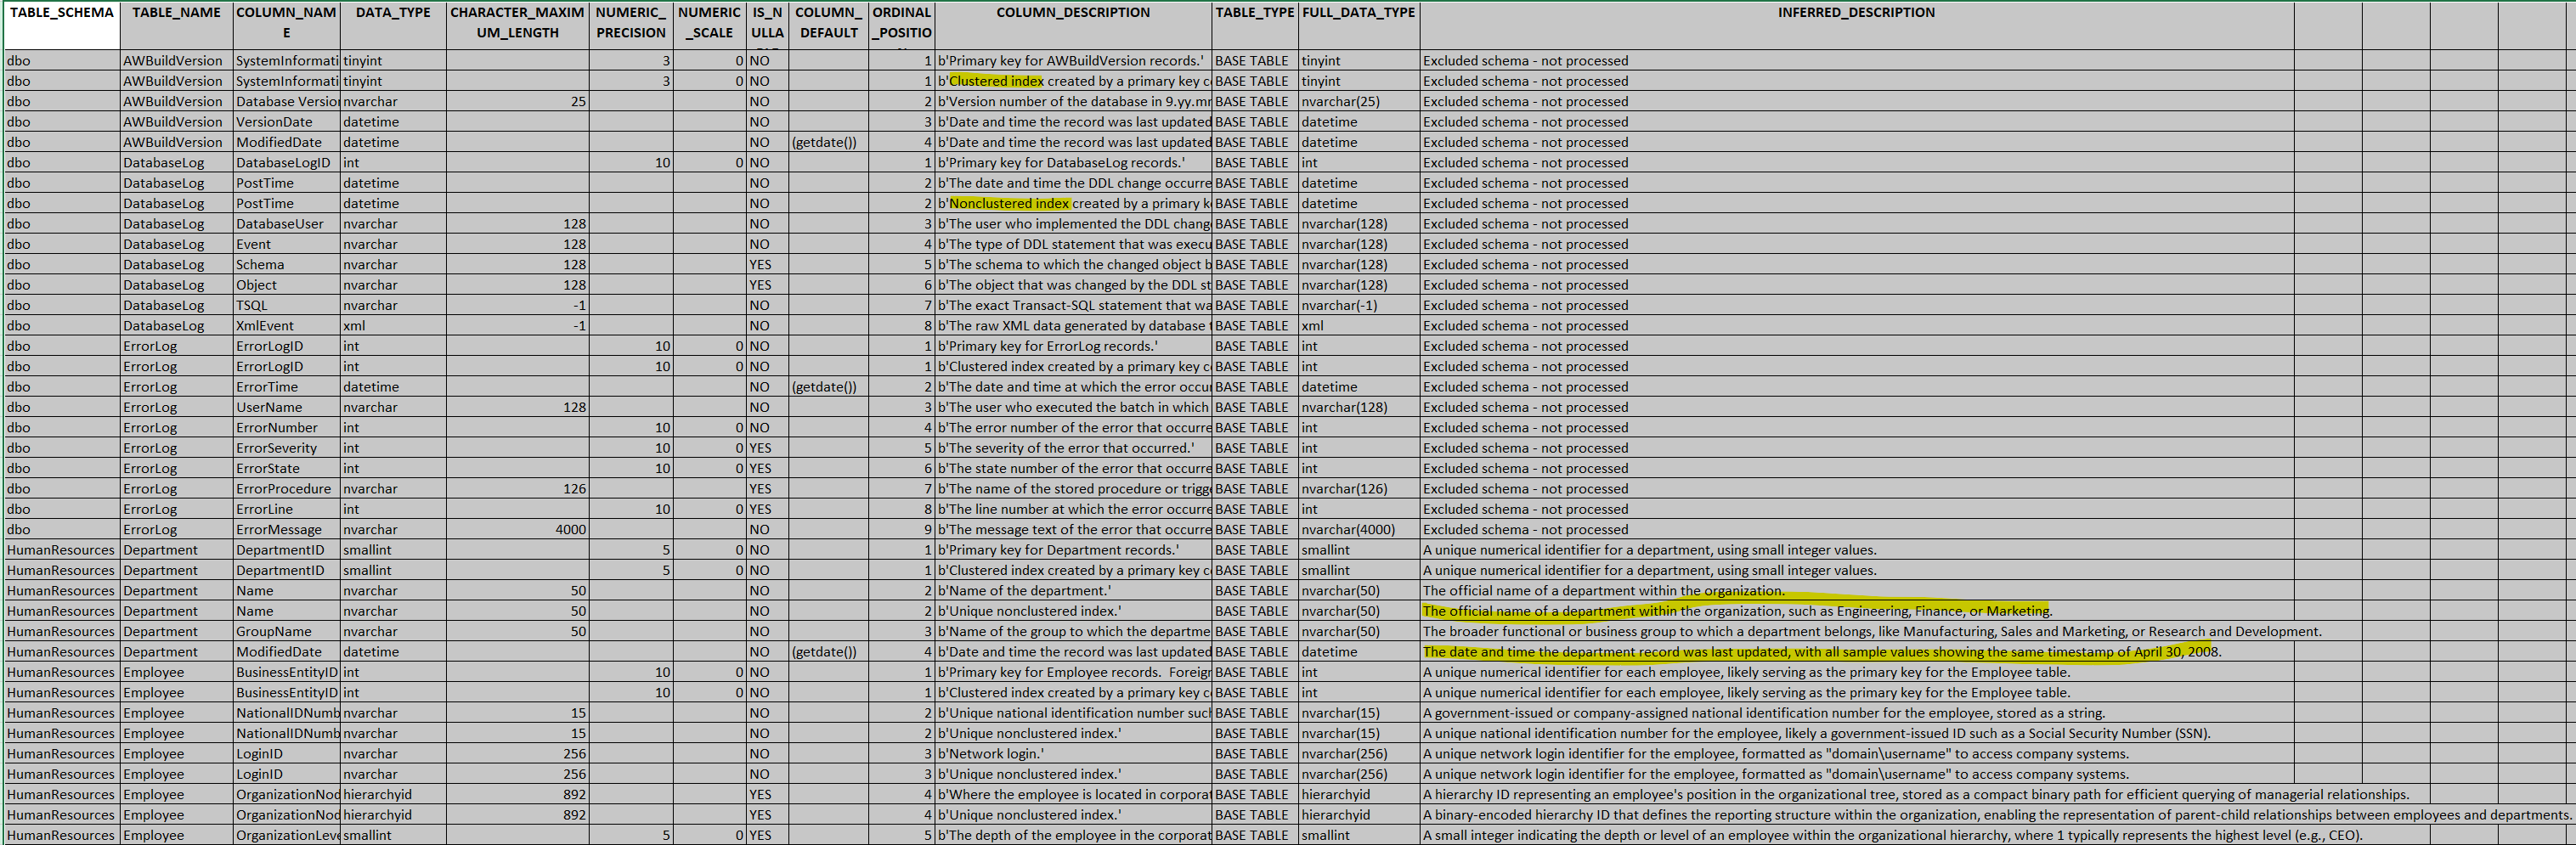

## 🐳 Start Docker Environment

First, start the OpenSearch cluster using the optimized docker-compose file:

In [1]:
%%bash
# Navigate to the docker compose directory and start the cluster
cd ../
docker compose -f docker-compose-fully-optimized.yml up -d

# Wait for the cluster to be ready
echo "Waiting for OpenSearch to start..."
sleep 30

# Check cluster health
curl -k -u admin:Developer@123 https://localhost:9200/_cluster/health?pretty

 Network 4text_to_sql_visualization_insights_opensearch-net  Creating
 Network 4text_to_sql_visualization_insights_opensearch-net  Created
 Volume "4text_to_sql_visualization_insights_opensearch-optimized-data2"  Creating
 Volume "4text_to_sql_visualization_insights_opensearch-optimized-data2"  Created
 Volume "4text_to_sql_visualization_insights_opensearch-optimized-data1"  Creating
 Volume "4text_to_sql_visualization_insights_opensearch-optimized-data1"  Created
time="2025-10-29T18:18:58-04:00" level=warning msg="Found orphan containers ([mssql-adventureworks 4text_to_sql_visualization_insights-adminer-1]) for this project. If you removed or renamed this service in your compose file, you can run this command with the --remove-orphans flag to clean it up."
 Container opensearch-optimized-dashboards  Creating
 Container opensearch-optimized-node1  Creating
 Container opensearch-optimized-node2  Creating
 Container opensearch-optimized-dashboards  Created
 Container opensearch-optimized

Waiting for OpenSearch to start...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   550  100   550    0     0   2111      0 --:--:-- --:--:-- --:--:--  2115


{
  "cluster_name" : "opensearch-optimized-cluster",
  "status" : "green",
  "timed_out" : false,
  "number_of_nodes" : 2,
  "number_of_data_nodes" : 2,
  "discovered_master" : true,
  "discovered_cluster_manager" : true,
  "active_primary_shards" : 3,
  "active_shards" : 6,
  "relocating_shards" : 0,
  "initializing_shards" : 0,
  "unassigned_shards" : 0,
  "delayed_unassigned_shards" : 0,
  "number_of_pending_tasks" : 0,
  "number_of_in_flight_fetch" : 0,
  "task_max_waiting_in_queue_millis" : 0,
  "active_shards_percent_as_number" : 100.0
}


## 📚 Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import time
import asyncio
import json
from opensearchpy import OpenSearch, helpers
from opensearchpy import AsyncOpenSearch
from opensearch_py_ml.ml_commons import MLCommonClient
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.style.use('default')
sns.set_palette("husl")

print("📦 All libraries imported successfully!")

📦 All libraries imported successfully!


## 🔌Connect to OpenSearch

In [4]:
# OpenSearch connection configuration
os_client = OpenSearch(
    hosts=[{'host': 'localhost', 'port': 9200}],
    http_auth=('admin', 'Developer@123'),
    use_ssl=True,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False
)

# Async client for performance comparison
async_client = AsyncOpenSearch(
    hosts=[{'host': 'localhost', 'port': 9200}],
    http_auth=('admin', 'Developer@123'),
    use_ssl=True,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False
)

# Initialize ML Commons client
ml_client = MLCommonClient(os_client)

# Test connection
try:
    info = os_client.info()
    print(f"✅ Connected to OpenSearch cluster: {info['cluster_name']}")
    print(f"📊 Version: {info['version']['number']}")
except Exception as e:
    print(f"❌ Connection failed: {e}")

✅ Connected to OpenSearch cluster: opensearch-optimized-cluster
📊 Version: 3.2.0


# Read Meta Dictionary

In [5]:
import pandas as pd
metadata_df_optimized = pd.read_excel(f"metadata_{db_connector.database}.xlsx",sheet_name="Metadata_Enhanced")
metadata_df_optimized = metadata_df_optimized[(metadata_df_optimized['INFERRED_COLUMN_DESCRIPTION'] != 'Excluded schema - not processed') & 
           (metadata_df_optimized['INFERRED_TABLE_DESCRIPTION'] != 'Excluded schema - not processed')]
metadata_df_optimized.reset_index(drop=True, inplace=True)
NEEDED_COLUMNS = [
    'TABLE_SCHEMA', 'TABLE_NAME', 'COLUMN_NAME', 'DATA_TYPE',
    'INFERRED_COLUMN_DESCRIPTION', 'INFERRED_TABLE_DESCRIPTION'
]
metadata_df_optimized = metadata_df_optimized[NEEDED_COLUMNS]
print(f"✅ Loaded enhanced metadata with {len(metadata_df_optimized)} columns from Excel.")
print(f"📋 Columns: {metadata_df_optimized.columns.tolist()}")
metadata_df_optimized.head(3)

✅ Loaded enhanced metadata with 464 columns from Excel.
📋 Columns: ['TABLE_SCHEMA', 'TABLE_NAME', 'COLUMN_NAME', 'DATA_TYPE', 'INFERRED_COLUMN_DESCRIPTION', 'INFERRED_TABLE_DESCRIPTION']


,TABLE_SCHEMA,TABLE_NAME,COLUMN_NAME,DATA_TYPE,INFERRED_COLUMN_DESCRIPTION,INFERRED_TABLE_DESCRIPTION
0,HumanResources,Department,DepartmentID,smallint,A unique numerical identifier for each departm...,This table stores department master data for o...
1,HumanResources,Department,Name,nvarchar,The official name of the organizational depart...,This table stores department master data for o...
2,HumanResources,Department,GroupName,nvarchar,The broader functional or executive group to w...,This table stores department master data for o...


## Create Generic Function to Generate OpenSearch Mappings from DataFrame

This function analyzes a pandas DataFrame and automatically generates OpenSearch index mappings based on the column data types.

**Key Features:**
- Maps pandas dtypes to appropriate OpenSearch field types
- Optionally creates corresponding `knn_vector` fields for text columns to support semantic search
- The vector fields are configured with:
  - Dimensions: 768 (standard for many embedding models)
  - Method: HNSW (Hierarchical Navigable Small World graphs)
  - Space type: L2 (Euclidean distance)
  - Engine: Lucene
- Handles nested objects and arrays by using the `nested` type
- Returns a complete index body structure ready for index creation

In [6]:
def create_opensearch_mappings(df, create_vectors=False, pipeline_name=None, exclude_from_vectors=None):
    """
    Create OpenSearch index mappings from a pandas DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to generate mappings from
    create_vectors : bool, default=False
        If True, creates corresponding knn_vector fields for text columns
        with dimensions=768, method=hnsw, space_type=l2, engine=lucene
    pipeline_name : str, optional
        If provided, sets this as the default_pipeline in index settings.
        Used for automatic embedding generation during ingestion.
    exclude_from_vectors : list of str, optional
        List of field names to exclude from vector creation.
        Default is ['id', 'title'] if not provided.
    
    Returns:
    --------
    dict
        A dictionary containing the index body with mappings suitable for 
        OpenSearch index creation
    
    Example:
    --------
    >>> mappings = create_opensearch_mappings(df, create_vectors=True, exclude_from_vectors=['id', 'title', 'metadata'])
    >>> os_client.indices.create(index='my_index', body=mappings)
    """
    import numpy as np
    
    # Set default exclusion list if not provided
    if exclude_from_vectors is None:
        exclude_from_vectors = ['id']
    
    # Define dtype mapping from pandas to OpenSearch
    dtype_mapping = {
        'int64': 'long',
        'int32': 'integer',
        'int16': 'short',
        'int8': 'byte',
        'float64': 'double',
        'float32': 'float',
        'bool': 'boolean',
        'datetime64[ns]': 'date',
        'object': 'text',  # Default for object types (strings)
    }
    
    properties = {}
    
    for column in df.columns:
        dtype_str = str(df[column].dtype)
        
        # Handle datetime types
        if 'datetime' in dtype_str:
            properties[column] = {'type': 'date'}
        
        # Handle boolean
        elif dtype_str == 'bool':
            properties[column] = {'type': 'boolean'}
        
        # Handle numeric types
        elif dtype_str in ['int64', 'int32', 'int16', 'int8']:
            properties[column] = {'type': dtype_mapping.get(dtype_str, 'long')}
        
        elif dtype_str in ['float64', 'float32']:
            properties[column] = {'type': dtype_mapping.get(dtype_str, 'double')}
        
        # Handle object types (strings, nested structures)
        elif dtype_str == 'object':
            # Check if column contains nested structures (dict/list)
            sample_value = df[column].dropna().iloc[0] if not df[column].dropna().empty else None
            
            if isinstance(sample_value, (dict, list)):
                # Use nested type for complex structures
                properties[column] = {'type': 'nested'}
            else:
                # Standard text field with keyword sub-field
                properties[column] = {
                    'type': 'text',
                    'fields': {
                        'keyword': {
                            'type': 'keyword',
                            'ignore_above': 256
                        }
                    }
                }
                
                # Optionally create vector field for text columns
                # Exclude specified fields from vector creation
                if create_vectors and column not in exclude_from_vectors:
                    vector_field_name = f"{column}_embedding"
                    properties[vector_field_name] = {
                        'type': 'knn_vector',
                        'dimension': 768,
                        'method': {
                            'name': 'hnsw',
                            'space_type': 'l2',
                            'engine': 'lucene',
                            'parameters': {}
                        }
                    }
        
        # Default fallback
        else:
            properties[column] = {'type': 'text'}
    
    # Create the settings object
    settings = {
        'index': {
            'number_of_shards': 1,
            'number_of_replicas': 1,
            'knn': create_vectors  # Enable k-NN only if vectors are being created
        }
    }
    
    # Add default_pipeline if provided
    if pipeline_name:
        settings['default_pipeline'] = pipeline_name
    
    # Create the complete index body
    index_body = {
        'settings': settings,
        'mappings': {
            'properties': properties
        }
    }
    
    return index_body

## Setup ML Model and Ingest Pipeline for Automatic Embeddings

Before creating an index with vector fields that automatically generates embeddings, we need to:

1. **Register and deploy a pre-trained embedding model** from HuggingFace
2. **Create an ingest pipeline** that uses this model to generate embeddings automatically during indexing
3. **Configure the index** to use this pipeline as the default pipeline

This setup enables automatic embedding generation during document ingestion, eliminating the need to manually create embeddings before indexing.

**Model Details:**
- Model: `huggingface/sentence-transformers/msmarco-distilbert-base-tas-b`
- Version: 1.0.1
- Format: TORCH_SCRIPT
- Dimensions: 768
- Use case: Semantic search, question-answering

## Configure ML Settings

Configure OpenSearch to allow ML operations on data nodes.

**Note:** In production environments with dedicated ML nodes, this configuration is not needed. For development/testing, we allow ML operations on data nodes.

In [7]:
# Configure cluster to allow ML operations
ml_settings = {
    "persistent": {
        "plugins.ml_commons.only_run_on_ml_node": False,
        "plugins.ml_commons.model_access_control_enabled": False,
        "plugins.ml_commons.native_memory_threshold": 99
    }
}

try:
    response = os_client.cluster.put_settings(body=ml_settings)
    print("="*80)
    print("ML Configuration Status:")
    print("="*80)
    print("✓ ML settings configured successfully")
    print("  - ML operations allowed on data nodes: True")
    print("  - Model access control: Disabled")
    print("  - Native memory threshold: 99%")
    print("\n✓ Cluster is ready for ML model deployment")
    print("="*80)
except Exception as e:
    print(f"⚠ Warning: Could not configure ML settings: {e}")
    print("  If ML nodes are properly configured, this error can be ignored")
    print("  Proceeding with model deployment...")

ML Configuration Status:
✓ ML settings configured successfully
  - ML operations allowed on data nodes: True
  - Model access control: Disabled
  - Native memory threshold: 99%

✓ Cluster is ready for ML model deployment


In [8]:
# Step 1: Register and deploy the sentence transformer model
print("="*80)
print("Registering and deploying ML model...")
print("="*80)

model_response = ml_client.register_pretrained_model(
    model_name="huggingface/sentence-transformers/msmarco-distilbert-base-tas-b",
    model_version="1.0.1",
    model_format="TORCH_SCRIPT",
    deploy_model=True,
    wait_until_deployed=True
)
model_id = model_response
print(f"Model ID: {model_id}")

# Step 2: Wait for model to be fully deployed
print("\nWaiting for model deployment...")
max_wait_time = 300  # 5 minutes max wait
start_time = time.time()

while True:
    model_info = ml_client.get_model_info(model_id)
    model_state = model_info.get('model_state', 'UNKNOWN')
    print(f"Current model state: {model_state}")
    
    if model_state == 'DEPLOYED':
        print("✓ Model deployed successfully!")
        break
    
    if time.time() - start_time > max_wait_time:
        print("⚠ Warning: Model deployment timeout. Proceeding anyway...")
        break
    
    time.sleep(5)

print(f"\n{'='*80}")
print(f"Model is ready for use")
print(f"{'='*80}")

Registering and deploying ML model...
Model was registered successfully. Model Id:  34CEMpoBf1t-tg6dTKVM
34CEMpoBf1t-tg6dTKVM
Task ID: PoyEMpoBbHKFBFNxr5s5
Model deployed successfully
Model ID: 34CEMpoBf1t-tg6dTKVM

Waiting for model deployment...
Current model state: DEPLOYED
✓ Model deployed successfully!

Model is ready for use


## Create Ingest Pipeline for Automatic Embedding Generation

Create an ingest pipeline that automatically generates embeddings for text fields during document ingestion.

The pipeline uses the `text_embedding` processor which:
- Takes text from specified source fields
- Generates 768-dimensional embeddings using the deployed model
- Stores embeddings in corresponding vector fields
- Runs automatically for every document ingested into indices using this pipeline

In [9]:
# Create a dynamic ingest pipeline based on text fields in the DataFrame
def create_embedding_pipeline(df, model_id, pipeline_name="text_to_bi", exclude_from_embeddings=None):
    """
    Create an ingest pipeline that generates embeddings for text fields.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze for text fields
    model_id : str
        The ID of the deployed ML model
    pipeline_name : str
        Name for the ingest pipeline
    exclude_from_embeddings : list of str, optional
        List of field names to exclude from embedding generation.
        Default is ['id'] if not provided.
    
    Returns:
    --------
    str : The pipeline name
    """
    # Set default exclusion list if not provided
    if exclude_from_embeddings is None:
        exclude_from_embeddings = ['id']
    
    # Identify text fields (excluding nested structures and excluded fields)
    text_fields = []
    for column in df.columns:
        dtype_str = str(df[column].dtype)
        if dtype_str == 'object':
            sample_value = df[column].dropna().iloc[0] if not df[column].dropna().empty else None
            if not isinstance(sample_value, (dict, list)) and column not in exclude_from_embeddings:
                text_fields.append(column)
    
    # Create field_map for text_embedding processor
    field_map = {}
    for field in text_fields:
        field_map[field] = f"{field}_embedding"
    
    # Create pipeline body
    pipeline_body = {
        "description": f"Embedding pipeline for {pipeline_name}",
        "processors": [
            {
                "text_embedding": {
                    "model_id": model_id,
                    "field_map": field_map
                }
            }
        ]
    }
    
    # Delete pipeline if it exists
    try:
        os_client.ingest.delete_pipeline(id=pipeline_name)
        print(f"Deleted existing pipeline: {pipeline_name}")
    except:
        pass
    
    # Create the pipeline
    os_client.ingest.put_pipeline(id=pipeline_name, body=pipeline_body)
    print(f"✓ Ingest pipeline created: {pipeline_name}")
    print(f"  Text fields to embed: {text_fields}")
    print(f"  Excluded fields: {exclude_from_embeddings}")
    print(f"  Field mappings: {field_map}")
    
    return pipeline_name

# Create the pipeline with custom exclusions
pipeline_name = create_embedding_pipeline(
    metadata_df_optimized, 
    model_id,
    exclude_from_embeddings=[]  # Exclude any ids or guids if needed
)
print(f"\n{'='*80}")
print(f"Pipeline '{pipeline_name}' is ready to use")
print(f"{'='*80}")

Deleted existing pipeline: text_to_bi
✓ Ingest pipeline created: text_to_bi
  Text fields to embed: ['TABLE_SCHEMA', 'TABLE_NAME', 'COLUMN_NAME', 'DATA_TYPE', 'INFERRED_COLUMN_DESCRIPTION', 'INFERRED_TABLE_DESCRIPTION']
  Excluded fields: []
  Field mappings: {'TABLE_SCHEMA': 'TABLE_SCHEMA_embedding', 'TABLE_NAME': 'TABLE_NAME_embedding', 'COLUMN_NAME': 'COLUMN_NAME_embedding', 'DATA_TYPE': 'DATA_TYPE_embedding', 'INFERRED_COLUMN_DESCRIPTION': 'INFERRED_COLUMN_DESCRIPTION_embedding', 'INFERRED_TABLE_DESCRIPTION': 'INFERRED_TABLE_DESCRIPTION_embedding'}

Pipeline 'text_to_bi' is ready to use


## Create Index with Pipeline and Ingest Data with Auto-Generated Embeddings

Now create an index that uses the ingest pipeline to automatically generate embeddings during document ingestion.

**Key Configuration:**
- `index.knn: true` - Enables k-NN functionality
- `default_pipeline: "squad_embedding_pipeline"` - Automatically processes all documents through the pipeline
- Vector fields are created for each text field to store the embeddings

**What happens during ingestion:**
1. Documents are sent to OpenSearch
2. The ingest pipeline intercepts them
3. Text fields are extracted and sent to the ML model
4. The model generates 768-dimensional embeddings
5. Embeddings are stored in the corresponding `_embedding` fields
6. The complete document (with embeddings) is indexed

This approach eliminates the need to manually generate embeddings before ingestion!

In [10]:
%%time

def generate_bulk_data(df, index_name):
    """
    Generator function to prepare data for bulk ingestion.
    Yields documents in the format required by opensearch helpers.bulk()
    """
    for idx, row in df.iterrows():
        # Convert row to dictionary
        doc = row.to_dict()
        
        # Convert numpy types to native Python types
        for key, value in doc.items():
            if isinstance(value, (np.integer, np.floating)):
                doc[key] = value.item()
            elif isinstance(value, np.ndarray):
                doc[key] = value.tolist()
        
        # Yield document with index name and _id
        yield {
            "_index": index_name,
            "_id": doc.get('id', idx),  # Use 'id' field if available, otherwise use index
            "_source": doc
        }

# Define index name
index_name_with_pipeline = "adventure_works_meta_ai_ready"

# Step 1: Generate mappings with vector fields AND pipeline configuration
mappings_with_pipeline = create_opensearch_mappings(
    metadata_df_optimized, 
    create_vectors=True,
    pipeline_name=pipeline_name
)

print("Generated OpenSearch mappings (WITH vector fields and pipeline):")
print(json.dumps(mappings_with_pipeline, indent=2, ensure_ascii=False))

# Verify the settings include both knn and default_pipeline
print(f"\n{'='*80}")
print("Index settings configuration:")
print(f"  - index.knn: {mappings_with_pipeline['settings']['index']['knn']}")
print(f"  - default_pipeline: {mappings_with_pipeline['settings'].get('default_pipeline', 'Not set')}")
print(f"{'='*80}")

# Step 2: Delete index if it exists
if os_client.indices.exists(index=index_name_with_pipeline):
    print(f"\nDeleting existing index: {index_name_with_pipeline}")
    os_client.indices.delete(index=index_name_with_pipeline)
    print(f"Index deleted successfully")

# Step 3: Create the index with pipeline-enabled mappings
print(f"\n{'='*80}")
print(f"Creating index: {index_name_with_pipeline}")
response = os_client.indices.create(index=index_name_with_pipeline, body=mappings_with_pipeline)
print(f"Index created successfully: {response}")
print(f"{'='*80}")

# Step 4: Ingest a SMALL sample (to test embedding generation)
# Note: Using only 100 documents for testing because embedding generation is compute-intensive
df_small_sample = metadata_df_optimized.head(1000)

print(f"\n{'='*80}")
print(f"Starting bulk ingestion of {len(df_small_sample)} documents...")
print("Note: Using small sample because embedding generation takes time")
start_time = time.time()

# Use bulk helper - the pipeline will automatically generate embeddings
success, failed = helpers.bulk(
    os_client,
    generate_bulk_data(df_small_sample, index_name_with_pipeline),
    chunk_size=5,  # Smaller chunks for embedding generation
    request_timeout=120,  # Longer timeout for model inference
    raise_on_error=False,
    raise_on_exception=False
)

elapsed_time = time.time() - start_time
print(f"Bulk ingestion completed in {elapsed_time:.2f} seconds")
print(f"Successfully indexed: {success} documents")
print(f"Failed: {failed} documents")
print(f"Average time per document: {elapsed_time/len(df_small_sample):.2f} seconds")
print(f"{'='*80}")

# Step 5: Verify ingestion and check embeddings
time.sleep(2)  # Wait for refresh
os_client.indices.refresh(index=index_name_with_pipeline)
count_response = os_client.count(index=index_name_with_pipeline)
print(f"\n{'='*80}")
print(f"Total documents in index '{index_name_with_pipeline}': {count_response['count']}")
print(f"{'='*80}")

# Fetch a document to verify embeddings were generated
search_response = os_client.search(
    index=index_name_with_pipeline, 
    body={"query": {"match_all": {}}, "size": 1}
)

if search_response['hits']['hits']:
    doc = search_response['hits']['hits'][0]['_source']
    
    # Check which embedding fields exist
    embedding_fields = [k for k in doc.keys() if k.endswith('_embedding')]
    print(f"\n{'='*80}")
    print(f"Embedding fields in document:")
    for field in embedding_fields:
        embedding = doc[field]
        if isinstance(embedding, list):
            print(f"  - {field}: {len(embedding)} dimensions")
            print(f"    First 5 values: {embedding[:5]}")
        else:
            print(f"  - {field}: {embedding}")
    print(f"{'='*80}")
    
    print(f"\nSample document with embeddings:")
    # Show document without full embedding arrays for readability
    doc_summary = {k: v if not k.endswith('_embedding') else f"[{len(v)} dimensions]" 
                   for k, v in doc.items()}
    print(json.dumps(doc_summary, indent=2, ensure_ascii=False))

Generated OpenSearch mappings (WITH vector fields and pipeline):
{
  "settings": {
    "index": {
      "number_of_shards": 1,
      "number_of_replicas": 1,
      "knn": true
    },
    "default_pipeline": "text_to_bi"
  },
  "mappings": {
    "properties": {
      "TABLE_SCHEMA": {
        "type": "text",
        "fields": {
          "keyword": {
            "type": "keyword",
            "ignore_above": 256
          }
        }
      },
      "TABLE_SCHEMA_embedding": {
        "type": "knn_vector",
        "dimension": 768,
        "method": {
          "name": "hnsw",
          "space_type": "l2",
          "engine": "lucene",
          "parameters": {}
        }
      },
      "TABLE_NAME": {
        "type": "text",
        "fields": {
          "keyword": {
            "type": "keyword",
            "ignore_above": 256
          }
        }
      },
      "TABLE_NAME_embedding": {
        "type": "knn_vector",
        "dimension": 768,
        "method": {
          "name": "hn

# Hybrid Search (Keyword + Semantic)

Hybrid search combines the best of both worlds:
- **Keyword Search (BM25)**: Exact term matching, good for specific queries
- **Semantic Search (k-NN)**: Meaning-based matching, good for conceptual queries

**Benefits:**
- Better recall: Finds documents that keyword search might miss
- Better precision: Combines semantic similarity with keyword relevance
- Flexible scoring: Can adjust weights between keyword and semantic components

**Implementation:**
We'll use a `bool` query with `should` clauses to combine both approaches.

In [13]:
def hybrid_search(query_text, index_name, fields_to_search=["title", "context", "question"], 
                  k=5, model_id=None, keyword_boost=1.0, semantic_boost=1.0):
    """
    Perform hybrid search combining keyword (BM25) and semantic (k-NN) search.
    
    Parameters:
    -----------
    query_text : str
        The search query text
    index_name : str
        Name of the index to search
    fields_to_search : list of str
        Fields to search in (both keyword and semantic)
        Default includes title for better semantic matching
    k : int
        Number of top results to return
    model_id : str, optional
        Model ID for embedding generation
    keyword_boost : float
        Boost factor for keyword search (default: 1.0)
    semantic_boost : float
        Boost factor for semantic search (default: 1.0)
    
    Returns:
    --------
    dict : Search results with combined scores
    """
    # Build keyword queries for each field
    keyword_queries = []
    for field in fields_to_search:
        keyword_queries.append({
            "match": {
                field: {
                    "query": query_text,
                    "boost": keyword_boost
                }
            }
        })
    
    # Build semantic queries for each field
    semantic_queries = []
    for field in fields_to_search:
        semantic_queries.append({
            "neural": {
                f"{field}_embedding": {
                    "query_text": query_text,
                    "model_id": model_id,
                    "k": k * 2,  # Retrieve more candidates for better results
                    "boost": semantic_boost
                }
            }
        })
    
    # Combine queries using bool should
    search_body = {
        "size": k,
        "query": {
            "bool": {
                "should": keyword_queries + semantic_queries,
                "minimum_should_match": 1
            }
        },
        # Return all fields except embeddings
        "_source": {
            "excludes": ["*_embedding"]
        },
        "explain": False  # Set to True to see score calculation details
    }
    
    return os_client.search(index=index_name, body=search_body)


# Example 1: Hybrid search with equal weights
print("="*100)
print("🔍 HYBRID SEARCH EXAMPLE 1: Equal Keyword + Semantic Weights")
print("="*100)
query = "Which table has product details?"
print(f"\nQuery: '{query}'")
print(f"Keyword Boost: 1.0, Semantic Boost: 1.0")

results = hybrid_search(
    query_text=query,
    index_name="adventure_works_meta_ai_ready",
    fields_to_search=["TABLE_NAME"],
    k=5,
    model_id=model_id,
    keyword_boost=1.0,
    semantic_boost=1.0
)

print(f"\n{'─'*100}")
print(f"Found {results['hits']['total']['value']} results")
print(f"{'─'*100}")

for i, hit in enumerate(results['hits']['hits'], 1):
    score = hit['_score']
    source = hit['_source']
    
    print(f"\n📄 Result {i} (Score: {score:.4f})")
    print(f"   Table Schema: {source.get('TABLE_SCHEMA', 'N/A')}")
    print(f"   Table Name: {source.get('TABLE_NAME', 'N/A')}")
    print(f"   Column Name: {source.get('COLUMN_NAME', 'N/A')}")
    print(f"   Data Type: {source.get('DATA_TYPE', 'N/A')}")
    print(f"   Column Description: {source.get('INFERRED_COLUMN_DESCRIPTION', 'N/A')[:150]}...")
    print(f"   Table Description: {source.get('INFERRED_TABLE_DESCRIPTION', 'N/A')[:150]}...")
    print(f"   {'-'*96}")

print(f"\n{'='*100}\n")

🔍 HYBRID SEARCH EXAMPLE 1: Equal Keyword + Semantic Weights

Query: 'Which table has product details?'
Keyword Boost: 1.0, Semantic Boost: 1.0

────────────────────────────────────────────────────────────────────────────────────────────────────
Found 35 results
────────────────────────────────────────────────────────────────────────────────────────────────────

📄 Result 1 (Score: 1.3197)
   Table Schema: Production
   Table Name: Product
   Column Name: ProductID
   Data Type: int
   Column Description: A unique numerical identifier assigned to each product in the Production.Product table. This is the primary key for the product catalog....
   Table Description: This table stores product master data for a manufacturing business. It contains detailed information about products including identification numbers, ...
   ------------------------------------------------------------------------------------------------

📄 Result 2 (Score: 1.3197)
   Table Schema: Production
   Table Name: Prod